# Introduction
In this notebook, I have used three scenarios for Contextual Bandit Problem and assessed various exploration approaches for them. The problem statement is recommending movie genres to users based on user data: age and gender. To avoid unnecessary complications, lets keep two categories of age (less than 15 and greater than 15) and gender (male and female). So age and gendr form the context for our contextual bandit problem and the actions are the genres: Action, Drama, Suspense, Romance, Comedy and Horror. The reward system used is described below.

In [2]:
# Install relevant libraries
!pip install vowpalwabbit 
!pip install boost
!apt-get install libboost-program-options-dev zlib1g-dev libboost-python-dev -y
!pip install vowpalwabbit

     |████████████████████████████████| 2.2MB 5.1MB/s 
  Created wheel for boost: filename=boost-0.1-cp37-none-any.whl size=12462 sha256=bcd28348564c478c659ede215e9ac9f6e6b13e56b7b41bc036b68cfa32f878e6
  Stored in directory: /root/.cache/pip/wheels/c9/7e/e1/dfb3e41d0b764a6fbb0d926f3dd67c2b729170643ff6558d65
Successfully built boost
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libboost-program-options-dev is already the newest version (1.65.1.0ubuntu1).
libboost-program-options-dev set to manually installed.
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
zlib1g-dev set to manually installed.
libboost-python-dev is already the newest version (1.65.1.0ubuntu1).
libboost-python-dev set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [3]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt

In [7]:
# The command sample_custom_pmf takes a list and gives us the index it chose and what the probability of choosing that index was.
def sample_custom_pmf(pmf):
    total = sum(pmf)
    scale = 1 / total
    pmf = [x * scale for x in pmf]
    draw = random.random()
    sum_prob = 0.0
    for index, prob in enumerate(pmf):
        sum_prob += prob
        if(sum_prob > draw):
            return index, prob

In [8]:
def get_action(vw, context, actions):
    vw_text_example = to_vw_example_format(context,actions)
    pmf = vw.predict(vw_text_example)
    chosen_action_index, prob = sample_custom_pmf(pmf)
    return actions[chosen_action_index], prob

In [9]:
def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_iterations', fontsize=14)
    plt.ylabel('ctr', fontsize=14)
    plt.ylim([0,1])

# Reward Distribution
There is a non zero reward assigned to top 2 preferences depending on the context features. The top choice has a reward of 1 (-1 cost) and the second preference will have a reward of 0.5 (-0.5 cost). For the rest of the recommendations which are not the top preferences, the reward is 0 (0 cost).

In [10]:
# VW tries to minimize loss/cost, therefore we will pass cost as -reward
GOOD_RECOMMENDATION = -1.0
AVERAGE_RECOMMENDATION = -0.5
POOR_RECOMMENDATION = 0.0

In [11]:
# This function modifies (context, action, cost, probability) to VW friendly format
def to_vw_example_format(context, actions, cb_label = None):
    if cb_label is not None:
        chosen_action, cost, prob = cb_label
    example_string = ""
    example_string += "shared |User user={} time_of_day={}\n".format(context["user_ages"], context["user_gender"])
    for action in actions:
        if cb_label is not None and action == chosen_action:
            example_string += "0:{}:{} ".format(cost, prob)
        example_string += "|Action article={} \n".format(action)
    #Strip the last newline
    return example_string[:-1]

In [13]:
user_ages = ['less than 15', 'greater than 15']
user_gender = ['Male', 'Female']
actions = ["Action", "Suspense", "Drama", "Comedy", "Romance", "Horror"]

def choose_user_ages(user_ages):
    return random.choice(user_ages)

def choose_user_gender(user_gender):
    return random.choice(user_gender)

# First Scenario
Initially we will consider some of the genres. We want the model to predict recommendations in the following order of preference with rewards given in brackets:

* Boys (less than 15): Action (1.0 reward) > Comedy (0.5 reward) > Others (0.0 reward)
* Girls (less than 15): Romance (1.0 reward) > Comedy (0.5 reward) > Others (0.0 reward)
* Men (greater than 15): Horror (1.0 reward) > Action (0.5 reward) > Others (0.0 reward)
* Women (greater than 15): Comedy (1.0 reward) > Romance (0.5 reward) > Others (0.0 reward)

In [14]:
def get_movie_cost(context,action):
    #print(context,action)
    if context['user_ages'] == "less than 15":
        if context['user_gender'] == "Male" and action == "Action":
            return GOOD_RECOMMENDATION
        elif context['user_gender'] == "Male" and action == "Comedy":
            return AVERAGE_RECOMMENDATION
        elif context['user_gender'] == "Female" and action == "Romance":
          return GOOD_RECOMMENDATION
        elif context['user_gender'] == "Female" and action == "Comedy":
          return AVERAGE_RECOMMENDATION
        else:
            return POOR_RECOMMENDATION
    elif context['user_ages'] == "greater than 15":
        if context['user_gender'] == "Male" and action == "Horror":
            return GOOD_RECOMMENDATION
        elif context['user_gender'] == "Male" and action == "Action":
            return AVERAGE_RECOMMENDATION
        elif context['user_gender'] == "Female" and action == "Comedy":
          return GOOD_RECOMMENDATION
        elif context['user_gender'] == "Female" and action == "Romance":
          return AVERAGE_RECOMMENDATION
        else:
            return POOR_RECOMMENDATION

In [15]:
def run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions, do_learn = True):
    cost_sum = 0.
    ctr = []

    start_counter = 1
    end_counter = start_counter + num_iterations
    for cost_function in cost_functions:
        for i in range(start_counter, end_counter):
            # 1. in each simulation choose a user age
            userAge = choose_user_ages(user_ages)
            # 2. choose time of day for a given user gender
            userGender = choose_user_gender(user_gender)

            # Construct context based on chosen user and time of day
            context = {'user_ages': userAge, 'user_gender': userGender}
            
            # 3. Use the get_action function we defined earlier
            action, prob = get_action(vw, context, actions)
            
            # 4. Get cost of the action we chose
            cost = cost_function(context, action)
            cost_sum += cost

            if do_learn:
                # 5. Inform VW of what happened so we can learn from it
                vw_format = vw.parse(to_vw_example_format(context, actions, (action, cost, prob)),pyvw.vw.lContextualBandit)
                # 6. Learn
                vw.learn(vw_format)

            # We negate this so that on the plot instead of minimizing cost, we are maximizing reward
            ctr.append(-1*cost_sum/i)
        start_counter = end_counter
        end_counter = start_counter + num_iterations

    return ctr


## Epsilon-greedy Exploration Approach
As we can see in the below, the performance of the model starts to decrease when epsilon is greater than 0.1 in the epsilon greedy method. For epsilon =0.05 and 0.1, the results are very close and in some trials in fact epsilon=0.1 performed better than 0.05. However, generally speaking, it is safe to say that as epsilon increases beyond 0.1 to 0.9 the model performance and ability to learning decreases.  

In the plot below, 
Blue curve corresponds to epsilon=0.05, 
Yellow curve corresponds to epsilon=0.1, 
Green curve corresponds to epsilon=0.6 and 
Red curve corresponds to epsilon=0.9


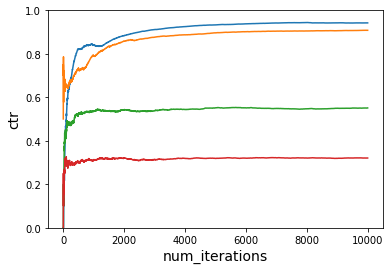

In [19]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.05")

print("In the plot below, \nBlue curve corresponds to epsilon=0.05, \nYellow curve corresponds to epsilon=0.1, \nGreen curve corresponds to epsilon=0.6 and \nRed curve corresponds to epsilon=0.9")

num_iterations = 10000
cost_functions = [get_movie_cost]
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(num_iterations, ctr)

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.1")

num_iterations = 10000
cost_functions = [get_movie_cost]
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(num_iterations, ctr)

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.6")

num_iterations = 10000
cost_functions = [get_movie_cost]
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(num_iterations, ctr)

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.9")

num_iterations = 10000
cost_functions = [get_movie_cost]
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(num_iterations, ctr)



## Explore-first Exploration Approach

As we can see from the graph, for the blue curve, first 100 examples or iterations are just exploring without learning whereas for the other yellow curve, first 1000 examples are exploration without learning. Both the curves after exploring start to learn very well as can be seen from the graph.


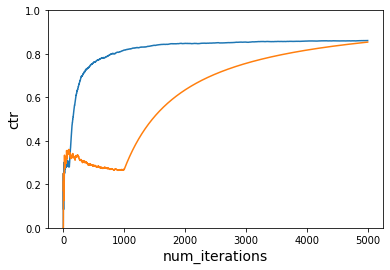

In [48]:
# Instantiate learner in VW first 100
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --first 100")

num_iterations = 5000
cost_functions = [get_movie_cost]
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(num_iterations, ctr)

# Instantiate learner in VW first 1000
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --first 1000")

num_iterations = 5000
cost_functions = [get_movie_cost]
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(num_iterations, ctr)

## Bagging Explorer
The blue curve corresponds to 100 different policies being trained on 100 different subsets of the data and the yellow curve corresponds to 1000 different policies trained on 1000 different subsets of the data. As we can see, the bagging explorer with argument m=100 (100 different policies) perform better than argument m=1000 (1000 different policies).

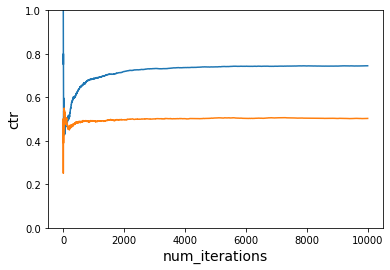

In [51]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --bag 100")

num_iterations = 10000
cost_functions = [get_movie_cost]
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)


plot_ctr(num_iterations, ctr)


# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --bag 1000")

num_iterations = 10000
cost_functions = [get_movie_cost]
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(num_iterations, ctr)

## Online Cover Approach
Blue curve in the plot below corresponds to argument m=1 and yellow curve corresponds to argument m=50 

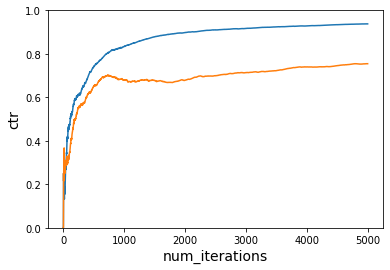

In [52]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --cover 1")

num_iterations = 5000
cost_functions = [get_movie_cost]
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)


plot_ctr(num_iterations, ctr)

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --cover 50")

num_iterations = 5000
cost_functions = [get_movie_cost]
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(num_iterations, ctr)

## Softmax Explorer

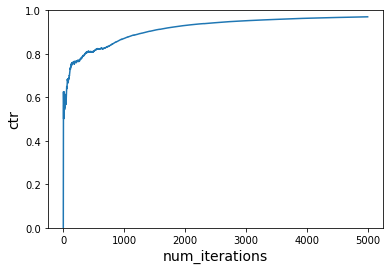

In [29]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --softmax --lambda 10")

num_iterations = 5000
cost_functions = [get_movie_cost]
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(num_iterations, ctr)

## RND (Random Network Distillation) Explorer

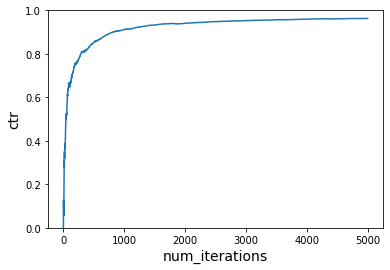

In [28]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --rnd 3 --epsilon 0.025 ")

num_iterations = 5000
cost_functions = [get_movie_cost]
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(num_iterations, ctr)

# Conclusion for First Scenario
 From the above results, several algorithms: Epsilon-greedy, Epsilon-first, Online Cover, Softmax explorer and RND explorer perform satisfactorily on the given contextual bandit problem. Now, lets modify the scenario and change the preferences of users.

# Second Scenario
Now we will modify the scenario. Over time it was observed that the choice of people change. So lets consider new preferences as defined below. We want the model to predict recommendations in the following order of preference with rewards given in brackets:

* Boys (less than 15): Comedy (1.0 reward) > Horror (0.5 reward) > Others (0.0 reward)
* Girls (less than 15): Comedy (1.0 reward) > Romance (0.5 reward) > Others (0.0 reward)

* Men (greater than 15): Action (1.0 reward) > Romance (0.5 reward) > Others (0.0 reward)
* Women (greater than 15): Romance (1.0 reward) > Horror (0.5 reward) > Others (0.0 reward)

Below are all the approaches for second scenario that we used above. 

In [18]:
def get_movie_cost2(context,action):
    #print(context,action)
    if context['user_ages'] == "less than 15":
        if context['user_gender'] == "Male" and action == "Comedy":
            return GOOD_RECOMMENDATION
        elif context['user_gender'] == "Male" and action == "Horror":
            return AVERAGE_RECOMMENDATION
        elif context['user_gender'] == "Female" and action == "Comedy":
          return GOOD_RECOMMENDATION
        elif context['user_gender'] == "Female" and action == "Romance":
          return AVERAGE_RECOMMENDATION
        else:
            return POOR_RECOMMENDATION
    elif context['user_ages'] == "greater than 15":
        if context['user_gender'] == "Male" and action == "Action":
            return GOOD_RECOMMENDATION
        elif context['user_gender'] == "Male" and action == "Romance":
            return AVERAGE_RECOMMENDATION
        elif context['user_gender'] == "Female" and action == "Romance":
          return GOOD_RECOMMENDATION
        elif context['user_gender'] == "Female" and action == "Horror":
          return AVERAGE_RECOMMENDATION
        else:
            return POOR_RECOMMENDATION

## Epsilon-greedy Exploration Approach

In the plot below, 
Blue curve corresponds to epsilon=0.05, 
Yellow curve corresponds to epsilon=0.1, 
Green curve corresponds to epsilon=0.6 and 
Red curve corresponds to epsilon=0.9


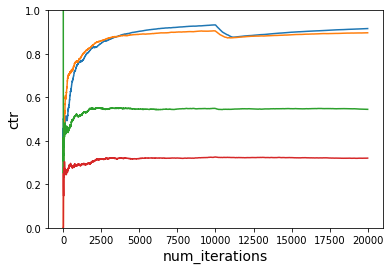

In [43]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.05")

print("In the plot below, \nBlue curve corresponds to epsilon=0.05, \nYellow curve corresponds to epsilon=0.1, \nGreen curve corresponds to epsilon=0.6 and \nRed curve corresponds to epsilon=0.9")

num_iterations = 10000
cost_functions = [get_movie_cost, get_movie_cost2]
total_iterations = num_iterations * len(cost_functions)
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(total_iterations, ctr)

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.1")

num_iterations = 10000
cost_functions = [get_movie_cost, get_movie_cost2]
total_iterations = num_iterations * len(cost_functions)
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(total_iterations, ctr)

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.6")

num_iterations = 10000
cost_functions = [get_movie_cost, get_movie_cost2]
total_iterations = num_iterations * len(cost_functions)
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(total_iterations, ctr)

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.9")

num_iterations = 10000
cost_functions = [get_movie_cost, get_movie_cost2]
total_iterations = num_iterations * len(cost_functions)
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(total_iterations, ctr)


## Explore-first Exploration Approach

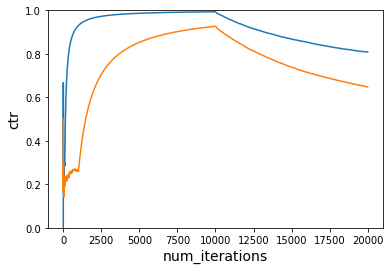

In [46]:
# Instantiate learner in VW first 100
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --first 100")

num_iterations = 10000
cost_functions = [get_movie_cost, get_movie_cost2]
total_iterations = num_iterations * len(cost_functions)
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(total_iterations, ctr)

# Instantiate learner in VW first 1000
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --first 1000")

num_iterations = 10000
cost_functions = [get_movie_cost, get_movie_cost2]
total_iterations = num_iterations * len(cost_functions)
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(total_iterations, ctr)

## Bagging Explorer

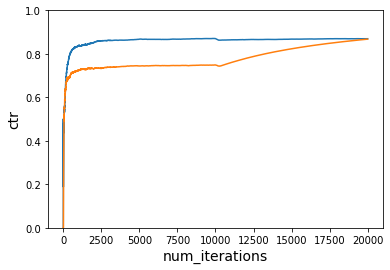

In [47]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --bag 100")

num_iterations = 10000
cost_functions = [get_movie_cost, get_movie_cost2]
total_iterations = num_iterations * len(cost_functions)
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(total_iterations, ctr)


# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --bag 1000")

num_iterations = 10000
cost_functions = [get_movie_cost, get_movie_cost2]
total_iterations = num_iterations * len(cost_functions)
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(total_iterations, ctr)

## Online Cover Approach

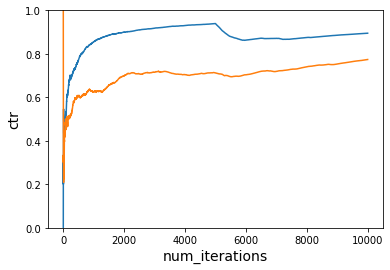

In [48]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --cover 1")

num_iterations = 5000
cost_functions = [get_movie_cost, get_movie_cost2]
total_iterations = num_iterations * len(cost_functions)
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(total_iterations, ctr)

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --cover 50")

num_iterations = 5000
cost_functions = [get_movie_cost, get_movie_cost2]
total_iterations = num_iterations * len(cost_functions)
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(total_iterations, ctr)

### Softmax Explorer

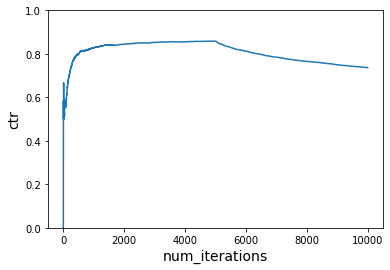

In [33]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --softmax --lambda 10")

num_iterations = 5000
cost_functions = [get_movie_cost, get_movie_cost2]
total_iterations = num_iterations * len(cost_functions)
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(total_iterations, ctr)

# RND (Random Network Distillation) Explorer

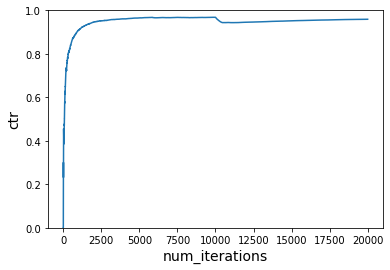

In [51]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --rnd 3 --epsilon 0.025 ")

num_iterations = 10000
cost_functions = [get_movie_cost, get_movie_cost2]
total_iterations = num_iterations * len(cost_functions)
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(total_iterations, ctr)

# Conclusion of Second Scenario:
From the plots above, evidently Softmax explorer and Epsilon-first explorer drop their performance when the cost function is changed. The other approaches have a drop but they recover eventually with iterations.

RND explorer seems to experience very little drop in the performance with the changing preferences and the corresponding cost functions. Hence it wouldn't be wrong to say that RND explorer is quite robust as compared to other approaches.

Lets move to the third scenario where we add change preferences of the users and start rewarding actions which have never seen a reward previously.

# Third Scenario
In this scenario, we also include Drama and Suspense in the preferences with non zero reward
* Boys (less than 15): Comedy (1.0 reward) > Suspense (0.5 reward) > Others (0.0 reward)
* Girls (less than 15): Drama (1.0 reward) > Romance (0.5 reward) > Others (0.0 reward)

* Men (greater than 15): Suspense (1.0 reward) > Drama (0.5 reward) > Others (0.0 reward)
* Women (greater than 15): Drama (1.0 reward) > Suspense (0.5 reward) > Others (0.0 reward)


In [17]:
def get_movie_cost3(context,action):
    #print(context,action)
    if context['user_ages'] == "less than 15":
        if context['user_gender'] == "Male" and action == "Comedy":
            return GOOD_RECOMMENDATION
        elif context['user_gender'] == "Male" and action == "Suspense":
            return AVERAGE_RECOMMENDATION
        elif context['user_gender'] == "Female" and action == "Drama":
          return GOOD_RECOMMENDATION
        elif context['user_gender'] == "Female" and action == "Romance":
          return AVERAGE_RECOMMENDATION
        else:
            return POOR_RECOMMENDATION
    elif context['user_ages'] == "greater than 15":
        if context['user_gender'] == "Male" and action == "Suspense":
            return GOOD_RECOMMENDATION
        elif context['user_gender'] == "Male" and action == "Drama":
            return AVERAGE_RECOMMENDATION
        elif context['user_gender'] == "Female" and action == "Drama":
          return GOOD_RECOMMENDATION
        elif context['user_gender'] == "Female" and action == "Suspense":
          return AVERAGE_RECOMMENDATION
        else:
            return POOR_RECOMMENDATION

# Epsilon-greedy Exploration Approach

In the plot below, 
Blue curve corresponds to epsilon=0.05, 
Yellow curve corresponds to epsilon=0.1, 
Green curve corresponds to epsilon=0.6 and 
Red curve corresponds to epsilon=0.9


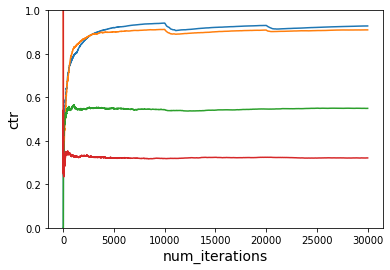

In [19]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.05")

print("In the plot below, \nBlue curve corresponds to epsilon=0.05, \nYellow curve corresponds to epsilon=0.1, \nGreen curve corresponds to epsilon=0.6 and \nRed curve corresponds to epsilon=0.9")

num_iterations = 10000
cost_functions = [get_movie_cost, get_movie_cost2, get_movie_cost3]
total_iterations = num_iterations * len(cost_functions)
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(total_iterations, ctr)

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.1")

num_iterations = 10000
cost_functions = [get_movie_cost, get_movie_cost2, get_movie_cost3]
total_iterations = num_iterations * len(cost_functions)
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(total_iterations, ctr)

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.6")

num_iterations = 10000
cost_functions = [get_movie_cost, get_movie_cost2, get_movie_cost3]
total_iterations = num_iterations * len(cost_functions)
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(total_iterations, ctr)

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --epsilon 0.9")

num_iterations = 10000
cost_functions = [get_movie_cost, get_movie_cost2, get_movie_cost3]
total_iterations = num_iterations * len(cost_functions)
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(total_iterations, ctr)


# Epsilon-first Exploration Approach

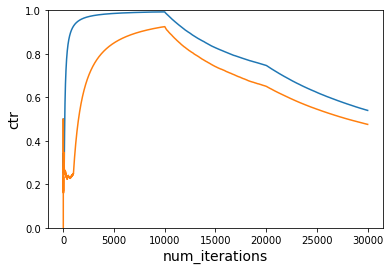

In [25]:
# Instantiate learner in VW first 100
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --first 100")

num_iterations = 10000
cost_functions = [get_movie_cost, get_movie_cost2, get_movie_cost3]
total_iterations = num_iterations * len(cost_functions)
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(total_iterations, ctr)

# Instantiate learner in VW first 1000
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --first 1000")

num_iterations = 10000
cost_functions = [get_movie_cost, get_movie_cost2, get_movie_cost3]
total_iterations = num_iterations * len(cost_functions)
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(total_iterations, ctr)

# Bagging Explorer

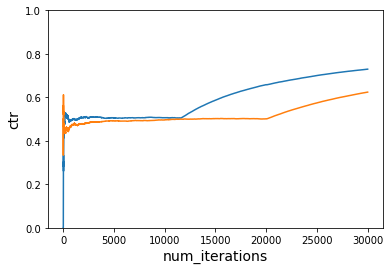

In [30]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --bag 100")

num_iterations = 10000
cost_functions = [get_movie_cost, get_movie_cost2, get_movie_cost3]
total_iterations = num_iterations * len(cost_functions)
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(total_iterations, ctr)


# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --bag 1000")

num_iterations = 10000
cost_functions = [get_movie_cost, get_movie_cost2, get_movie_cost3]
total_iterations = num_iterations * len(cost_functions)
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(total_iterations, ctr)

# Online Cover Approach

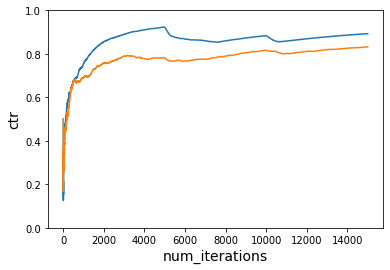

In [27]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --cover 1")

num_iterations = 5000
cost_functions = [get_movie_cost, get_movie_cost2, get_movie_cost3]
total_iterations = num_iterations * len(cost_functions)
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(total_iterations, ctr)

# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --cover 50")

num_iterations = 5000
cost_functions = [get_movie_cost, get_movie_cost2, get_movie_cost3]
total_iterations = num_iterations * len(cost_functions)
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(total_iterations, ctr)

# Softmax Explorer

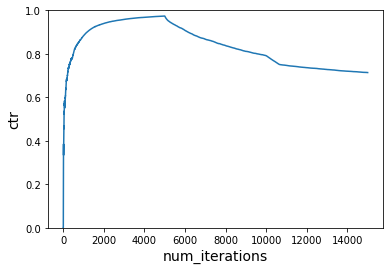

In [36]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --softmax --lambda 10")

num_iterations = 5000
cost_functions = [get_movie_cost, get_movie_cost2, get_movie_cost3]
total_iterations = num_iterations * len(cost_functions)
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(total_iterations, ctr)

# RND (Random Network Distillation) Explorer

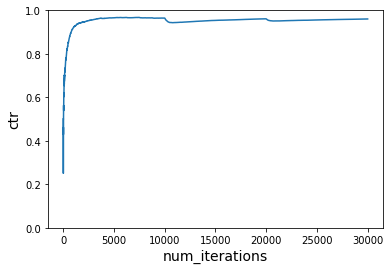

In [19]:
# Instantiate learner in VW
vw = pyvw.vw("--cb_explore_adf -q UA --quiet --rnd 3 --epsilon 0.025 ")

num_iterations = 10000
cost_functions = [get_movie_cost, get_movie_cost2, get_movie_cost3]
total_iterations = num_iterations * len(cost_functions)
ctr = run_movie_simulation(vw, num_iterations, user_ages, user_gender, actions, cost_functions)

plot_ctr(total_iterations, ctr)

# Conclusion of third scenario
From the above graph, we can see that there is minimal drop in the performance of the RND explorer which seem to further prove its robust nature. The other algorithm which performs good with minimal drops in the performance for all the scenario besides RND is Epsilon-greedy approach with epsilon less than 0.1.